##### Import Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import truncnorm
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
from scipy.stats import norm
from ROOT import TFile, TTree

# Add the parent directory of simpleparameterisation to the sys.path list
sys.path.append('../simpleparamaterisation/')

# Now you can import simpleparameterisation from the new location
import TPCevt as TPC


Welcome to JupyROOT 6.28/00


##### Helper Function and Constant

In [3]:
def driftsigma_trans(z, det):
    return np.sqrt(2*z*det.D_xy/det.vdrift)

def driftsigma_long(z, det):
    return np.sqrt(2*z*det.D_z/det.vdrift)

nsigma_extend=3
thresh=1e1

##### Main Function

In [4]:
def getData(f, saveevt):
    # Get Center Coordinate
    max_z = 0
    min_z = 0
    for evt in f.data:
        if evt.z0 > max_z:
            max_z = evt.z0
        if evt.z0 < min_z:
            min_z = evt.z0
    center_z = (max_z - min_z)/2
    
    # Shift Coordinate
    for i, evt in enumerate(f.data):
        PrimaryEvt = pd.DataFrame({'x': np.asarray(evt.x)/10 + center_z/10, 'y': np.asarray(evt.y)/10 + center_z/10, 
                        'z': np.asarray(evt.z)/10 + center_z/10, 
                    'Edep': np.asarray(evt.edep)*1000})
        if i == saveevt:
            break
    return PrimaryEvt

def generateCarriers(PrimaryEvt, det):
    PrimaryEvt['NIP'] = np.random.poisson(PrimaryEvt['Edep']/det.wval)

def driftCarriers(PrimaryEvt, det):
    '''
    Drift the primary carriers down to the gain stage.

    Inputs:

    - PrimaryEvt is a Pandas DataFrame with at least (x,y,z,Edep,NIP).

    - det is an instance of TPCevt.Detector, with the gas properties and drift field set.

    Returns a dataframe of drifted carriers with (index in PrimaryEvt, x, y, dt)
    '''
    Ndrifted = int(PrimaryEvt['NIP'].sum())
    if not Ndrifted>0:
        return pd.DataFrame(columns=['idx_PrimaryEvt', 'x', 'y', 'dt'])
    #drifteddict = {'idx_PrimaryEvt': np.empty(Ndrifted, dtype=np.int), 'x': np.empty(Ndrifted, dtype=np.float),
    #              'y': np.empty(Ndrifted, dtype=np.float), 'dt': np.empty(Ndrifted, dtype=np.float)}
    DriftedEvt = pd.DataFrame(columns=['idx_PrimaryEvt', 'x', 'y', 'dt'], 
            index=np.arange(PrimaryEvt.index[0],Ndrifted+PrimaryEvt.index[0],1))
    counter = int(PrimaryEvt.index[0])
    #offset = int(PrimaryEvt.index[0])
    #This loop assumes the index increases by one unit with each entry.
    for i in PrimaryEvt.index:
        numtodrift = int(PrimaryEvt['NIP'][i])
        thisz = PrimaryEvt['z'][i]
        DriftedEvt['idx_PrimaryEvt'].loc[counter:(counter+numtodrift)-1] = i
        DriftedEvt['x'].loc[counter:(counter+numtodrift)-1] = PrimaryEvt['x'][i] + np.random.normal(loc=0,
                                                                scale=driftsigma_trans(thisz, det),
                                                                size=numtodrift)
        DriftedEvt['y'].loc[counter:(counter+numtodrift)-1] = PrimaryEvt['y'][i] + np.random.normal(loc=0,
                                                                scale=driftsigma_trans(thisz, det),
                                                                size=numtodrift)
        DriftedEvt['dt'].loc[counter:(counter+numtodrift)-1] = (thisz + np.random.normal(loc=0,
                                                                scale=driftsigma_long(thisz, det),
                                                                size=numtodrift))/det.vdrift
        counter += numtodrift
    
    return DriftedEvt

def gainAndReadout(DriftedEvt, det, nsigma_extend=3, thresh=1e1):
    '''
    Apply avalanche gain and read out the event. Only reads out a subset of co-ords about the track, on a grid.
    
    Inputs:

    - DriftedEvt is a dataframe containing the x,y,dt co-ordinates of every drifted carrier.

    - det is an instance of TPCevt.Detector, with the gain/readout info set.

    - nsigma_extend is the # of point spread function std to extend by about the track extremities.

    - thresh is the threshold (in number of electrons, below which the output is cut.

    Returns a pandas dataframe with (x,y,dt) readout co-ordinates and the number of electrons being read out
    '''
    minvals = DriftedEvt.min()
    maxvals = DriftedEvt.max()
    ReadoutGrid = np.mgrid[np.floor((minvals['x']- det.PSFmean - 
                                    nsigma_extend*det.PSFstd)/det.pitch_x)*det.pitch_x:
                            np.ceil((maxvals['x'] + det.PSFmean + 
                                    nsigma_extend*det.PSFstd)/det.pitch_x)*det.pitch_x:
                            det.pitch_x,
                            
                            np.floor((minvals['y'] - det.PSFmean - 
                                nsigma_extend*det.PSFstd)/det.pitch_y)*det.pitch_y:
                            np.ceil((maxvals['y'] + det.PSFmean + 
                                nsigma_extend*det.PSFstd)/det.pitch_y)*det.pitch_y:
                            det.pitch_y,
                            
                            np.floor((minvals['dt'] - 
                                nsigma_extend*det.gain_sigma_t)/det.samplerate)*det.samplerate:
                            np.ceil((maxvals['dt'] + 
                                nsigma_extend*det.gain_sigma_t)/det.samplerate)*det.samplerate:
                            det.samplerate]
    pos = np.stack(ReadoutGrid, axis=3)
    ReadoutEvt = None
    for i in DriftedEvt.index:
        thisGain = np.random.exponential(scale=det.gain_mean) # bikin gain banyak dulu baru di loop
        rv = multivariate_normal([DriftedEvt.iloc[i]['x'], DriftedEvt.iloc[i]['y'], 
            DriftedEvt.iloc[i]['dt']], np.diag([det.PSFstd, det.PSFstd,det.gain_sigma_t]))
        if ReadoutEvt is None:
            #The factor pitch_x*pitch_y*sample_rate converts from probability density 
            #to 'normalised' probability
            ReadoutEvt = rv.pdf(pos)*det.pitch_x*det.pitch_y*det.samplerate*thisGain
        else:
            ReadoutEvt += rv.pdf(pos)*det.pitch_x*det.pitch_y*det.samplerate*thisGain

    #Only record readout elements where Nel > thresh
    themask = ReadoutEvt >= thresh
    if np.sum(themask) == 0:
        print('No channels above threshold!')
        return pd.DataFrame(columns=['x', 'y', 'dt', 'Nel'])
    try:
        return pd.DataFrame({'x': ReadoutGrid[0][themask].flatten(), 'y': ReadoutGrid[1][themask].flatten(), 
            'dt': ReadoutGrid[2][themask].flatten(), 'Nel': ReadoutEvt[themask]})
    except:
        print(f'DriftedEvt: {DriftedEvt}')
        print(f'themask: {themask}\nReadoutGrid[0]: {ReadoutGrid[0]}\nReadoutEvt: {ReadoutEvt}\nReadoutGrid: {ReadoutGrid}')
        print(f'ReadoutGrid.shape: {ReadoutGrid.shape}, ReadoutEvt.shape: {ReadoutEvt.shape}, themask.shape = {themask.shape}')
        raise

def plotReadout(ReadoutEvt):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*1000)
    plt.title(" X-Y Chart ")
    # plt.savefig('export/chart_X-Y.png')

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.dt, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*1000)
    plt.title(" X-dT Chart ")
    # plt.savefig('export/chart_X-dT.png')

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.dt, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*1000)
    plt.title(" Y-dT Chart ")
    # plt.savefig('export/chart_Y-dT.png')

    plt.show()

##### Main Program

In [5]:
# Define the Detector
det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")

# Open ROOT FIle
f = TFile.Open("../files/simOut_28796KShell.root")

##### Primary Event

In [41]:
%%timeit
saveevt = 1
PrimaryEvt = getData(f, saveevt)

6.53 s ± 407 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
saveevt = 1
PrimaryEvt = getData(f, saveevt)
PrimaryEvt

,x,y,z,Edep
0,23.962170,26.851755,26.814911,0.043670
1,23.962368,26.851991,26.814917,0.083792
2,23.962329,26.852121,26.814934,0.136588
3,23.962125,26.851796,26.814872,0.049380
4,23.961355,26.849986,26.815058,0.021973
5,23.957602,26.848080,26.816329,0.665817
6,23.956783,26.845911,26.814511,0.376015
7,23.957281,26.844575,26.812790,0.433897
8,23.957093,26.846053,26.812740,0.016025
9,23.957713,26.844907,26.813409,1.052442


##### Carrier Event

In [44]:
%%timeit
generateCarriers(PrimaryEvt, det)

129 µs ± 6.71 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
generateCarriers(PrimaryEvt, det)
PrimaryEvt

,x,y,z,Edep,NIP
0,23.962170,26.851755,26.814911,0.043670,1
1,23.962368,26.851991,26.814917,0.083792,6
2,23.962329,26.852121,26.814934,0.136588,3
3,23.962125,26.851796,26.814872,0.049380,2
4,23.961355,26.849986,26.815058,0.021973,3
5,23.957602,26.848080,26.816329,0.665817,30
6,23.956783,26.845911,26.814511,0.376015,15
7,23.957281,26.844575,26.812790,0.433897,17
8,23.957093,26.846053,26.812740,0.016025,1
9,23.957713,26.844907,26.813409,1.052442,35


##### Drifted Event

In [46]:
%%timeit
DriftedEvt = TPC.drift_carriers(PrimaryEvt, det)

4.06 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
DriftedEvt = TPC.drift_carriers(PrimaryEvt, det)
DriftedEvt

,idx_PrimaryEvt,x,y,dt
0,0,23.896524,26.951516,0.157456
1,1,23.920202,26.864901,0.158165
2,1,24.004483,27.030919,0.157531
3,1,24.012724,26.923532,0.157504
4,1,23.992096,26.838336,0.1586
...,...,...,...,...
108,9,24.117032,26.847967,0.157718
109,9,23.945847,26.8909,0.15865
110,9,24.090148,26.665813,0.157191
111,9,24.054933,26.789826,0.158212


##### Readout Event

In [49]:
%%timeit
ReadoutEvt = gainAndReadout(DriftedEvt, det, nsigma_extend=5)

30.7 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
ReadoutEvt = gainAndReadout(DriftedEvt, det, nsigma_extend=5)
ReadoutEvt

,x,y,dt,Nel
0,23.5,26.5,0.158,181.440175
1,23.5,26.6,0.157,78.876744
2,23.5,26.6,0.158,1507.227421
3,23.5,26.7,0.157,335.673847
4,23.5,26.7,0.158,4667.563678
...,...,...,...,...
256,24.3,27.1,0.158,1753.824122
257,24.3,27.1,0.159,55.573920
258,24.3,27.2,0.157,28.537694
259,24.3,27.2,0.158,154.915088


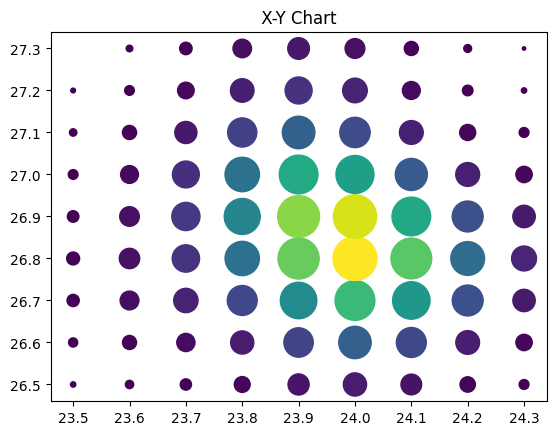

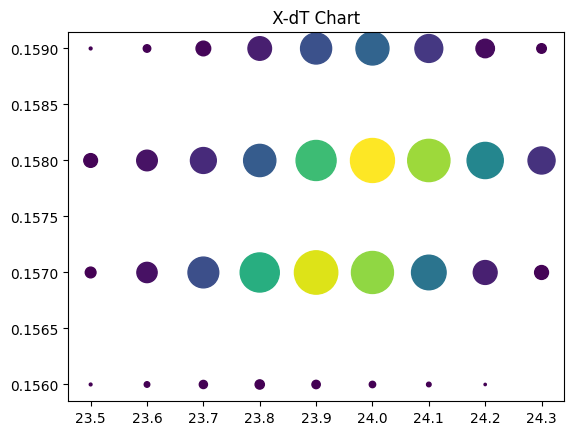

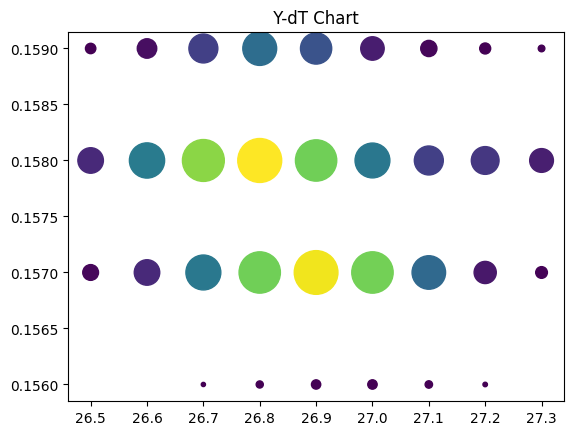

In [10]:
plotReadout(ReadoutEvt)

##### Time Benchmark

In [11]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes


sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('DriftedEvt', 20020),
 ('ReadoutEvt', 8516),
 ('LogNorm', 1688),
 ('TFile', 1688),
 ('TTree', 1688),
 ('PrimaryEvt', 564),
 ('driftCarriers', 152),
 ('driftsigma_long', 152),
 ('driftsigma_trans', 152),
 ('gainAndReadout', 152),
 ('generateCarriers', 152),
 ('getData', 152),
 ('open', 152),
 ('plotReadout', 152),
 ('TPC', 72),
 ('f', 72),
 ('np', 72),
 ('pd', 72),
 ('plt', 72),
 ('det', 56),
 ('multivariate_normal', 56),
 ('norm', 56),
 ('truncnorm', 56),
 ('nsigma_extend', 28),
 ('saveevt', 28),
 ('thresh', 24)]

In [35]:
ReadoutEvt

,x,y,dt,Nel
0,23.6,26.5,0.157,4023.413473
1,23.6,26.5,0.158,198.751363
2,23.6,26.5,0.159,61.829152
3,23.6,26.6,0.157,8308.990906
4,23.6,26.6,0.158,3490.366913
...,...,...,...,...
183,24.2,27.1,0.158,21198.911133
184,24.2,27.1,0.159,3047.743089
185,24.2,27.2,0.157,249.262821
186,24.2,27.2,0.158,6149.225981


9913148.8547559


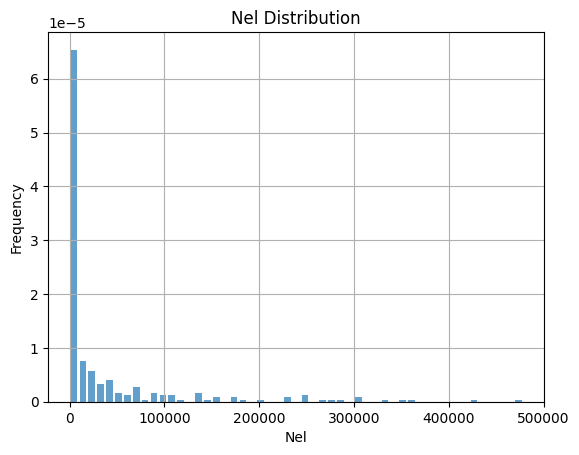

In [12]:

ReadoutEvt = gainAndReadout(DriftedEvt, det, nsigma_extend=3)
print(ReadoutEvt['Nel'].sum())
plt.hist(ReadoutEvt['Nel'], bins='auto', alpha=0.7, rwidth=0.75, density=True)

plt.xlabel('Nel')
plt.ylabel('Frequency')
plt.title('Nel Distribution')
plt.grid(True)
plt.show()